In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
#loading data for training for models
training = pd.read_csv("/content/drive/MyDrive/TwitterSentimentClassificationData/training_dataset.csv", 
                       encoding = "ISO-8859-1",
                       header = None,
                       names = ["Sentiment", "ids", "date", "flag", "user", "tweet"])


#loading data to test our model
testing = pd.read_csv("/content/drive/MyDrive/TwitterSentimentClassificationData/test_dataset.csv", 
                      encoding = "ISO-8859-1", 
                      header = None,
                      names = ["Sentiment", "ids", "date", "flag", "user", "tweet"])

#Exploratory Data Analysis

In [117]:
#first 5 observations of training data
training.head(5)

,Sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [118]:
#first 5 observations of testing data
testing.head(5)

,Sentiment,ids,date,flag,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [119]:
print("Shape of Training Data: ",training.shape)    #printing number of rows and columns in training data

Shape of Training Data:  (1600000, 6)


In [120]:
print("Shape of Testing Data: ",testing.shape)      #printing number of rows and columns in testing data

Shape of Testing Data:  (498, 6)


In [121]:
#First 5 observations of training data after changing values of Sentiment Column
training.head(5)

,Sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [122]:
#First 5 observations of testing data after changing values of Sentiment Column
testing.head(5)

,Sentiment,ids,date,flag,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


0 represents negative sentiment and 4 represents positive sentiment. We will be changing 0 to negative and 4 to positive in both training and testing data.

In [123]:
training["Sentiment"] = np.where(training["Sentiment"] == 0, "Negative", "Positive")    #converting 0 to Negative and 4 to Positive in training data
testing["Sentiment"] = np.where(testing["Sentiment"] == 0, "Negative", "Positive")      #converting 0 to Negative and 4 to Positive in testing data

##Count of data samples for Positive and Negative Sentiments.

In [124]:
#separating positive sentiment tweets and negative sentiment tweets
positives = training[training['Sentiment'] == 'Positive']
negatives = training[training['Sentiment'] == 'Negative']

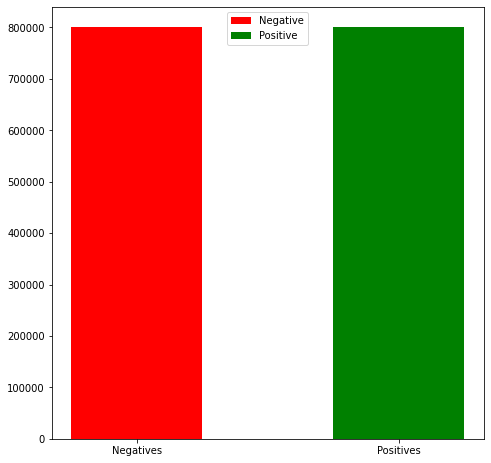

In [125]:
#plotting a bar graph of count of rows for positive tweets and negative tweets.
fig = plt.figure(figsize = (6, 6)) #adding figure
ax = fig.add_axes([0, 0, 1, 1])  #adding axis to our figure
ax.bar("Negatives", len(negatives), color = "Red", width = 0.5, label = "Negative")   #bar chart for negative sentiment tweets
ax.bar("Positives", len(positives), color = "Green", width = 0.5, label = "Positive") #bar chart for positive sentiment tweets
ax.legend(loc = "upper center")     #plotting the legend for bar chart
plt.show()

We 80,000 tweets which are labels with positive sentiment and 80,000 with negative sentiment so our dataset is **balanced**.

##Count of words in positive and negative sentiments.Distribution plot for count of words in both classes.

In [126]:
#count of words in positive sentiments
count_words_positive = positives['tweet'].str.split().apply(lambda w: len(w))     #calculating count of words in positive sentiment tweets

print("Count of Words in each tweet for Positive Sentiment: \n",count_words_positive)   #printing count of words in positive sentiment tweets

Count of Words in each tweet for Positive Sentiment: 
 800000      8
800001     14
800002     27
800003     21
800004      7
           ..
1599995    11
1599996    11
1599997    11
1599998    12
1599999     5
Name: tweet, Length: 800000, dtype: int64


In [127]:
#count of words in negative sentiments
count_words_negative = negatives['tweet'].str.split().apply(lambda w: len(w))     #calculating count of words in negative sentiment tweets

print("Count of Words in each tweet for Negative Sentiment: \n",count_words_negative)   #printing count of words in negative sentiment tweets

Count of Words in each tweet for Negative Sentiment: 
 0         19
1         21
2         18
3         10
4         21
          ..
799995    10
799996     3
799997     6
799998    17
799999    15
Name: tweet, Length: 800000, dtype: int64


In [128]:
#defining a function plot distribution plot for various counts
def plot_distplot(countPositive, countNegative, titlePositive, titleNegative):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))     #defining a figure and two subplots within it for positive and negative tweets
  sns.distplot(countPositive, ax = ax1, color = "Green")      #plotting distribution plot of counts of for positive tweets
  ax1.set_title(titlePositive) 
  sns.distplot(countNegative, ax = ax2, color = "Red")        #plotting distribution plot of counts of for negative tweets
  ax2.set_title(titleNegative)
  plt.show()

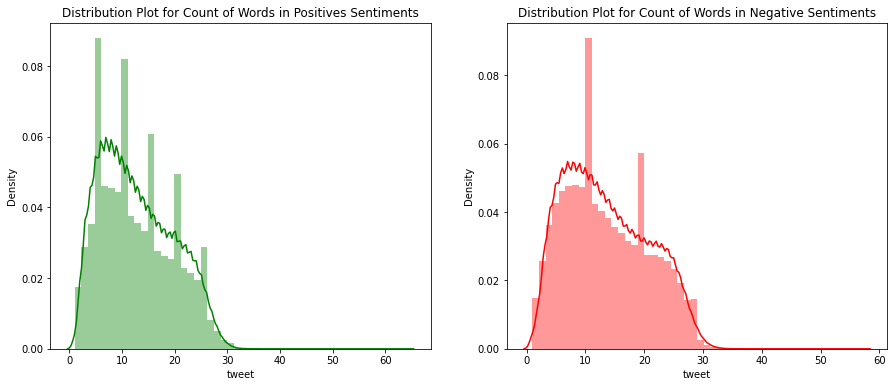

In [129]:
#distribution plot of count of words in positive and negative sentiments
plot_distplot(count_words_positive, count_words_negative, "Distribution Plot for Count of Words in Positives Sentiments", "Distribution Plot for Count of Words in Negative Sentiments")

##Count of Punctuations

In [130]:
#counting number of punctuations in positive and negative tweets
count_punctuations_postives = positives['tweet'].apply(lambda w: len([p for p in str(w) if p in string.punctuation]))
count_punctuations_negatives = negatives['tweet'].apply(lambda w: len([p for p in str(w) if p in string.punctuation]))

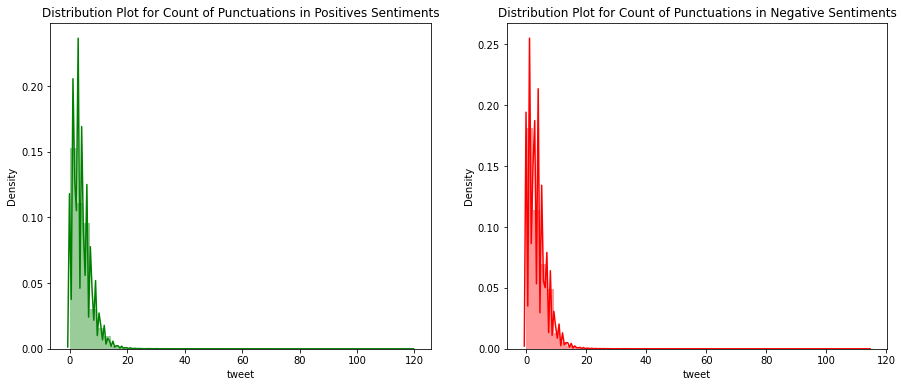

In [131]:
plot_distplot(count_punctuations_postives, count_punctuations_negatives, "Distribution Plot for Count of Punctuations in Positives Sentiments", "Distribution Plot for Count of Punctuations in Negative Sentiments")

##Count of Stop Words

In [132]:
stops=set(stopwords.words('english'))   #defining a set of stopwords using stopwords from nltk library


#count number of stop words in postive and negative sentiment tweets
count_stop_positives = positives['tweet'].apply(lambda w: len([s for s in str(w).split() if s in stops]))
count_stop_negatives = negatives['tweet'].apply(lambda w: len([s for s in str(w).split() if s in stops]))

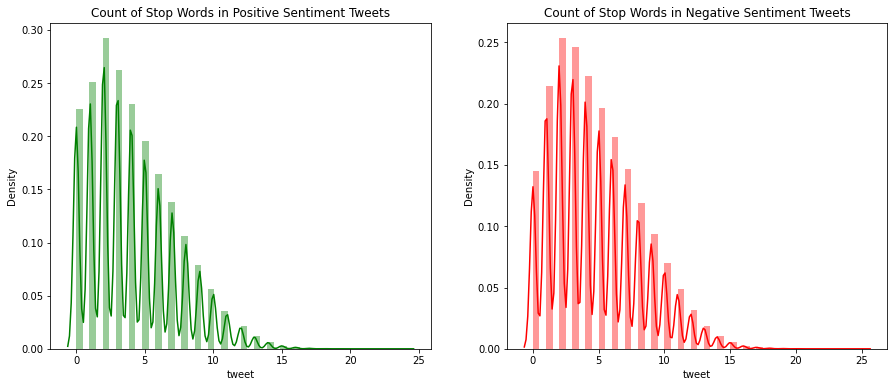

In [133]:
#plotting count stop words in positive and negative sentiments
plot_distplot(count_stop_positives, count_stop_negatives, "Count of Stop Words in Positive Sentiment Tweets", "Count of Stop Words in Negative Sentiment Tweets")

##Count of URLs

In [134]:
#counting number of URLs in positive and negative tweets
count_url_positives = positives['tweet'].apply(lambda w: len([s for s in str(w).lower().split() if 'http' in s or 'https' in s]))
count_url_negatives = negatives['tweet'].apply(lambda w: len([s for s in str(w).lower().split() if 'http' in s or 'https' in s]))

URL count Distionary for Positive Tweets:  {0: 753765, 1: 45295, 2: 841, 3: 79, 4: 13, 5: 7}
URL count Distionary for Negative Tweets:  {0: 775987, 1: 23653, 2: 336, 3: 20, 4: 4}


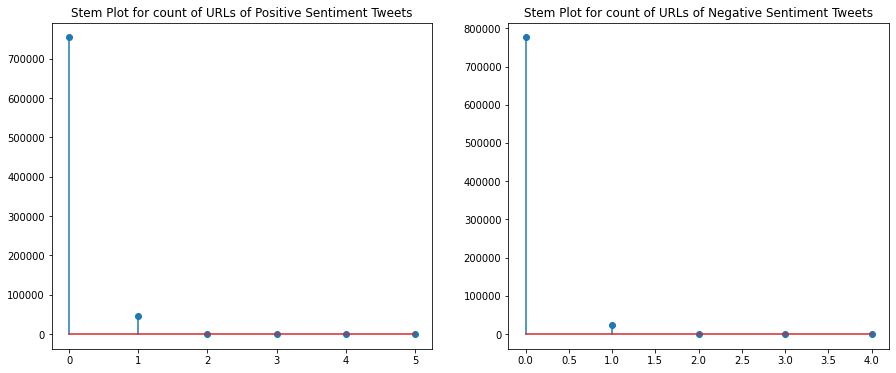

In [135]:
pos = count_url_positives.value_counts().to_dict()    #creating a dictionary of count of tweets with total urls for positive tweets
neg = count_url_negatives.value_counts().to_dict()    #creating a dictionary of count of tweets with total urls for negative tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6)) #figure with 2 subplots

#pie chart for positive tweets
count = list(pos.keys())    #list of keys from pos dicionary
values = list(pos.values())   #list repestive to key from dictionary
ax1.stem(count, values)   #plotting the stem plot for URL count of Positive Sentiment Tweets
ax1.set_title("Stem Plot for count of URLs of Positive Sentiment Tweets")
print("URL count Distionary for Positive Tweets: ", pos)    #printing the pos dictionary


#pie chart for negative tweets
count = list(neg.keys())      #list of keys from neg dicionary
values = list(neg.values())   #list repestive to key from dictionary
ax2.stem(count, values)   #plotting the stem plot for URL count of Negative Sentiment Tweets
ax2.set_title("Stem Plot for count of URLs of Negative Sentiment Tweets")
print("URL count Distionary for Negative Tweets: ", neg)    #printing the neg dictionary


plt.show()

From the plots of counts we can see that each tweet contains lots of Stop Words, Punctuations and few tweets also contain URLs. During Data cleaning we need to remove all of this.

In [136]:
#definfing a function to plot word cloud
def wordcloud(sentiment): 
  stop_words = set(STOPWORDS)
  comment = ''
  for tweet in sentiment.tweet:
    t = str(tweet)

    tokens = t.split()

    for i in range(len(tokens)):
      tokens[i] = tokens[i].lower()

    comment += " ".join(tokens)+ " " 

  word_cloud = WordCloud(width = 800, 
                        height = 800,
                        background_color = 'white',
                        stopwords = stop_words,
                        min_font_size = 10).generate(comment)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(word_cloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()

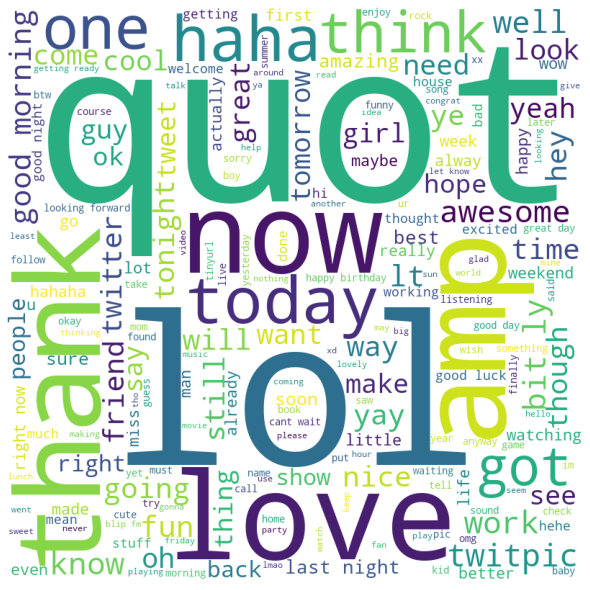

In [137]:
#wordcloud of positives after cleaning data
#separating positive sentiment tweets and negative sentiment tweets
positives = training[training['Sentiment'] == 'Positive']
negatives = training[training['Sentiment'] == 'Negative']

wordcloud(positives)    #wordcloud for positive sentiment tweets

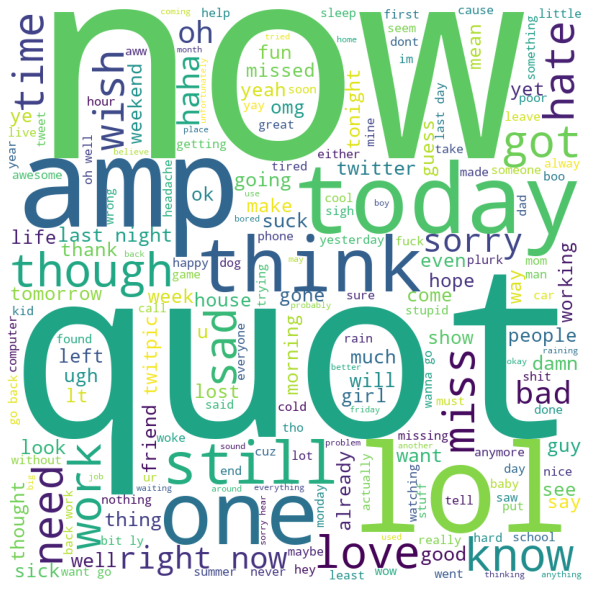

In [138]:
wordcloud(negatives)    #wordcloud for negative sentiment tweets

#Data Cleaning

##Dropping columns

As we want to classify sentiment of tweets as positive or negativem information regarding ids, date, flag and user is not relevant for us so we will be dropping them.

In [139]:
#dropping unnecessary columns from training and testing sets
training = training.drop(['ids', 'date', 'flag', 'user'], axis = 1)
testing = testing.drop(['ids', 'date', 'flag', 'user'], axis = 1)

##Converting Tweets to lowercase

In [140]:
#convering all tweets to lowercase
training['tweet'] = training['tweet'].str.lower()

##Removing Punctuations

In [141]:
#function to remove punctuations
def clean_punctuations(string1):
  temp = string1.maketrans("", "", string.punctuation)
  return string1.translate(temp)

training['tweet'] = training['tweet'].apply(lambda w: clean_punctuations(w))

print("Training Dataset after removing punctuations: \n")
training

Training Dataset after removing punctuations: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats a b...
1,Negative,is upset that he cant update his facebook by t...
2,Negative,kenichan i dived many times for the ball manag...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,nationwideclass no its not behaving at all im ...
...,...,...
1599995,Positive,just woke up having no school is the best feel...
1599996,Positive,thewdbcom very cool to hear old walt intervie...
1599997,Positive,are you ready for your mojo makeover ask me fo...
1599998,Positive,happy 38th birthday to my boo of alll time tup...


##Removing Stop Words

In [142]:
#function to remove stop words
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stops])
training['tweet'] = training['tweet'].apply(lambda text: cleaning_stopwords(text))
training

,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing URLs

In [143]:
#funtion to remove URLs from dataset
def clean_url(string1):
  string1 = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string1, flags=re.MULTILINE)
  return string1

training['tweet'] = training['tweet'].apply(lambda w: clean_url(w))

training

,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing Emojis

In [144]:
#function to remove emojis
def remove_emoji(string):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  string = emoji_pattern.sub(r'', string)
  return string

training['tweet'] = training['tweet'].apply(lambda w: remove_emoji(w))

training

,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing Numeric Values

In [145]:
#function to remove numeric values
def remove_numeric(string):
  return re.sub('[0-9]+', '', string)

training['tweet'] = training['tweet'].apply(lambda w: remove_numeric(w))

training

,Sentiment,tweet
0,Negative,switchfoot httptwitpiccomyzl awww thats bummer...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save r...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy th birthday boo alll time tupac amaru sh...


#Data Pre-processing

##Implementing Tokenization

In [146]:
#defining function to tokenize tweets
def tokenize(tweet):
  tweet = word_tokenize(tweet)
  return tweet

training['tweet'] = training['tweet'].apply(lambda w: tokenize(w))
training

,Sentiment,tweet
0,Negative,"[switchfoot, httptwitpiccomyzl, awww, thats, b..."
1,Negative,"[upset, cant, update, facebook, texting, might..."
2,Negative,"[kenichan, dived, many, times, ball, managed, ..."
3,Negative,"[whole, body, feels, itchy, like, fire]"
4,Negative,"[nationwideclass, behaving, im, mad, cant, see]"
...,...,...
1599995,Positive,"[woke, school, best, feeling, ever]"
1599996,Positive,"[thewdbcom, cool, hear, old, walt, interviews,..."
1599997,Positive,"[ready, mojo, makeover, ask, details]"
1599998,Positive,"[happy, th, birthday, boo, alll, time, tupac, ..."


##Implementing Lemmatization

In [147]:
#applying lemmatization on tokenized tweets using nltk's WordNetLemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    out_list = []
    for word in data:
      temp = lm.lemmatize(word)
      out_list.append(temp)
    return out_list
training['tweet'] = training['tweet'].apply(lambda x: lemmatizer_on_text(x))
training

,Sentiment,tweet
0,Negative,"[switchfoot, httptwitpiccomyzl, awww, thats, b..."
1,Negative,"[upset, cant, update, facebook, texting, might..."
2,Negative,"[kenichan, dived, many, time, ball, managed, s..."
3,Negative,"[whole, body, feel, itchy, like, fire]"
4,Negative,"[nationwideclass, behaving, im, mad, cant, see]"
...,...,...
1599995,Positive,"[woke, school, best, feeling, ever]"
1599996,Positive,"[thewdbcom, cool, hear, old, walt, interview, ..."
1599997,Positive,"[ready, mojo, makeover, ask, detail]"
1599998,Positive,"[happy, th, birthday, boo, alll, time, tupac, ..."


##Splitting Data into Train and Test sets.

In [148]:
x = training.tweet    #independent variable
y = training.Sentiment  #target variable

In [149]:
#splitting data into training and testing sets keeping 70% for training and 30% for testing
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

##Implementing TF-IDF Vectorizer

In [150]:
#converting words in tweets to vector(numbers) using sklearn's TfidfVectorizer
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)  
tfidf.fit(xTrain)
print('No. of feature_words: ', len(tfidf.get_feature_names()))

No. of feature_words:  612697


In [151]:
xTrain = tfidf.transform(xTrain)    #transforming xTrain using Tf-Idf
print(xTrain)

  (0, 590375)	0.3298491415384918
  (0, 580588)	0.1230868096367894
  (0, 552850)	0.18015815017369327
  (0, 530822)	0.45195441813118914
  (0, 515436)	0.15282257115723358
  (0, 496469)	0.20179223606021796
  (0, 458693)	0.19314127623184896
  (0, 421422)	0.17122339494969782
  (0, 369401)	0.2329401098993691
  (0, 346509)	0.1585599622322674
  (0, 336946)	0.21159650027839624
  (0, 265716)	0.16316795408156243
  (0, 195518)	0.2689693984487109
  (0, 186309)	0.22128005698277814
  (0, 125541)	0.3802716481433311
  (0, 93686)	0.27524256257405677
  (0, 18254)	0.12712185287821998
  (1, 516501)	0.27890609589872634
  (1, 508704)	0.30356062779828197
  (1, 501648)	0.2439094034190797
  (1, 488310)	0.45318132457543486
  (1, 400642)	0.20518996190705968
  (1, 284441)	0.2713115861663437
  (1, 166074)	0.21924654201720964
  (1, 62267)	0.33309125016299407
  :	:
  (1119997, 448637)	0.393568994890173
  (1119997, 431131)	0.7602814496689552
  (1119997, 34665)	0.5167935405463296
  (1119998, 575407)	0.2384779598556033
 

In [152]:
xTest = tfidf.transform(xTest)    #transforming xTest using Tf-Idf
print(xTest)

  (0, 399207)	0.37319275852614714
  (0, 208799)	0.320108454097494
  (0, 87371)	0.7178603010008404
  (0, 8293)	0.49288368896316714
  (1, 556335)	0.2596464719882461
  (1, 449438)	0.580040778087141
  (1, 361438)	0.6051646627506541
  (1, 99054)	0.2674040302686638
  (1, 26478)	0.39800404632878245
  (2, 582340)	0.24853016833549296
  (2, 560704)	0.41581132385164954
  (2, 541796)	0.13616511636311018
  (2, 540619)	0.45523058123799515
  (2, 495247)	0.2973205992203126
  (2, 385007)	0.17518828371120387
  (2, 378206)	0.19707335414415633
  (2, 320608)	0.12941806804953665
  (2, 304905)	0.14182956429951257
  (2, 301410)	0.29333835114771173
  (2, 257727)	0.15836184750247012
  (2, 194718)	0.22987819399583612
  (2, 191201)	0.17380268918936617
  (2, 156203)	0.2026305678256578
  (2, 132570)	0.265998541930689
  (2, 72237)	0.19690922318422585
  :	:
  (479997, 541796)	0.16078954343214655
  (479997, 473516)	0.37992607539513973
  (479997, 360568)	0.3364608182572022
  (479997, 328068)	0.41040274441100677
  (4799

#Model Implementation

##Bernoulli Naive Bayes

In [153]:
#defining a function to evaluate models
def model_evaluation(model, prediction):
  #reporting accuracy
  acc = accuracy_score(prediction, yTest)
  print("Accuracy: ", acc)

  #plotting confusion matrix
  print("\n\n")
  cm = confusion_matrix(yTest, prediction, labels = model.classes_)
  fig = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
  fig.plot()
  plt.show()

  #displaying classification report
  print("\n\n")
  print(classification_report(yTest, prediction, target_names = model.classes_))

Accuracy:  0.7738645833333333





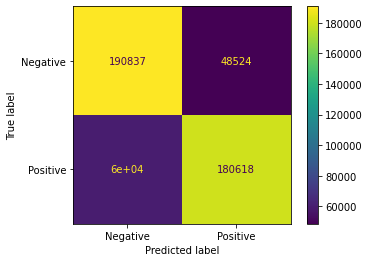




              precision    recall  f1-score   support

    Negative       0.76      0.80      0.78    239361
    Positive       0.79      0.75      0.77    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



In [154]:
bnbModel = BernoulliNB()    #defining Bernoulli Naive Bayes Model
bnbModel.fit(xTrain, yTrain)    #training the model
y_predbnb = bnbModel.predict(xTest)   #making prediction
model_evaluation(bnbModel, y_predbnb)   #evaluating model

##Logistic Regression

Accuracy:  0.7856166666666666





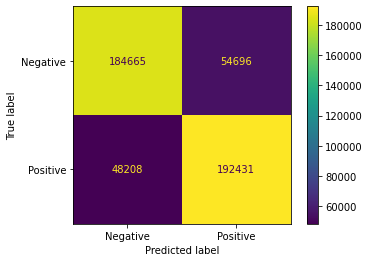




              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    239361
    Positive       0.78      0.80      0.79    240639

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



In [155]:
lrModel = LogisticRegression()  #defining Logistic Regression Model
lrModel.fit(xTrain, yTrain)   #training the model
y_predlr = lrModel.predict(xTest) #making predictions
model_evaluation(lrModel, y_predlr) #evaluating model

##Linear Support Vector Machine

Accuracy:  0.7778708333333333





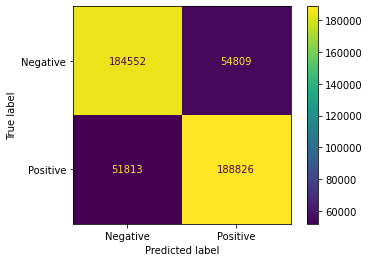




              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78    239361
    Positive       0.78      0.78      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



In [156]:
svmModel = LinearSVC()    #defining Linear Support Vector Machine Model
svmModel.fit(xTrain, yTrain)  #training the model
pred_svm = svmModel.predict(xTest)    #making predictions
model_evaluation(svmModel, pred_svm)    #evaluating model